In [68]:
import json
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [70]:
sys.path.append(os.path.join('..', 'src'))

In [71]:
import importlib
import s05_2_feature_engineering
# importlib.reload(model)
importlib.reload(s05_2_feature_engineering)
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# Data capture

In [72]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

X_train           = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
X_test            = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
X_train_onehot    = pd.read_csv(os.path.join(inputs, 'X_train_onehot.csv'), index_col='id')
X_test_onehot     = pd.read_csv(os.path.join(inputs, 'X_test_onehot.csv'), index_col='id')
y_train           = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test            = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

# Machine Learning

In [73]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# Calculating final score with a test set

In [74]:
def get_transformations(X_set, y_set, cols,
               build_polynomals_method=False, 
                label_transformation_type=None, do_treat_skewness=False,
               imputation=None, scaler=None,
               ):
    X_set = X_set.copy()
#     if encoding == 'one-hot':
#         set_name = set_name+'_oh'
#     elif encoding == 'ordinal':
#         set_name = set_name
#     if treat_collinearity:
#         set_name = set_name+'_oh_nocol'
#     X_set = data_dict[set_name]
    print(cols)
    print(X_set.columns.to_list())
    X_set = X_set[cols]
#     X_set = X_set[['cycle']]
    
#     if build_polynomals_method: 
#         X_train_set = build_polynomials(X_set, ProjectParameters().numerical_cols, method = build_polynomals_method)
#     if label_transformation_type:
#         y_set = transform_label(y_set, label_transformation_type)
#     if do_treat_skewness:
#         X_set = treat_skewness(X_set, set_name)
        
    if scaler:
        X_set = scale.fit_transform(X_set)
        X_set = pd.DataFrame(X_set, columns = X_set.columns)
    if imputation:
        X_set.fillna(imputation)
    
    return X_set, y_set

In [75]:
columns = X_train.columns.to_list()

In [76]:
label_transformation_type = None

# X_train, y_train = get_transformations(
#         X_train, y_train, columns,
#         build_polynomals_method=None, do_treat_skewness=False,
#         imputation=None, scaler=None)

X_test, y_test = get_transformations(
        X_test, y_test, columns,
        build_polynomals_method=None, do_treat_skewness=False,
        imputation=None, scaler=None)

['transactiondt', 'transactionamt', 'productcd', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'p_emaildomain', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'd1', 'd2', 'd3', 'd4', 'd5', 'd10', 'd11', 'd15', 'm4', 'if_anomaly']
['transactiondt', 'transactionamt', 'productcd', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'p_emaildomain', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'd1', 'd2', 'd3', 'd4', 'd5', 'd10', 'd11', 'd15', 'm4', 'if_anomaly']


# load results
Capture best parameters of chosen model which were obtained during cross validation

In [77]:
def load_json_results(model_type):
    filepath = os.path.join(model_outputs, model_type+'.json')
    with open(filepath, 'r') as file:
        json_results = json.load(file)
    model = json_results[model_type]
#     model = json_results
    return model

# build model to apply on test set

In [78]:
def build_model(ml_model_type, X, y):
    ml_model = load_json_results(ml_model_type)

    if ml_model_type.startswith('tree_rf'):
        params = {}
        cols = ml_model['columns']
        for k,v in ml_model['best_params'].items():
            k = k[7:]
            params[k] = v

        model = RandomForestClassifier()

    elif ml_model_type.startswith('tree_xgb'):
        params = ml_model['best_params']
        cols = ml_model['columns']
        
        model = XGBClassifier()
        
        X = X[cols]

    for k,v in params.items(): 
        setattr(model, k, v)

    model.fit(X, y)
    
    return model, cols

In [79]:
# ['tree_xgb', 'tree_xgb_select', 'tree_xgb_select_weight']
ml_model = 'tree_xgb_select'

model, columns = build_model(ml_model, X_train, y_train)
X_test = X_test[columns]
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# calculate test score 
main metric: mean squared error for regression, f1_score for binary target

In [80]:
# print('mean squared error:', round(mean_squared_error(y_test, y_pred), 3))
# print('r2_score', round(r2_score(y_test, y_pred),3))
# print('mean_absolute_error', round(mean_absolute_error(y_test, y_pred),3))
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))
print('accuracy_score', round(accuracy_score(y_test, y_pred), 3))
print('log_loss', round(log_loss(y_test, y_pred_prob), 3))
print('f1_score', round(f1_score(y_test, y_pred, average='binary'), 3))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      2899
         1.0       0.71      0.25      0.37       101

    accuracy                           0.97      3000
   macro avg       0.84      0.62      0.68      3000
weighted avg       0.97      0.97      0.96      3000

accuracy_score 0.971
log_loss 0.107
f1_score 0.368


In [81]:
def plot_confusion_matrix(arr):
    arr = np.round(arr, 2)

    fig, ax = plt.subplots()
    im = ax.imshow(arr, cmap='Blues')

    # Loop over data dimensions and create text annotations.
    for i in range(len(arr[0])):
        for j in range(len(arr[1])):
            text = ax.text(j, i, arr[i, j],
                           ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    fig.tight_layout()
    plt.show()

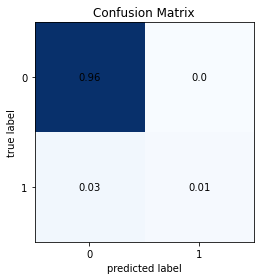

In [82]:
cm = confusion_matrix(y_test, y_pred, normalize='all')
plot_confusion_matrix(cm)

# sample prediction
predict first 10 entries

# rebuild model for entire dataset

In [83]:
X = X_train.copy().append(X_test)
y = y_train.copy().append(y_test)
# y.extend(y_test)

# ml_model = 'tree_randomforest'
ml_model = 'tree_xgb'
final_model = build_model(ml_model, X, y)

# save results

In [84]:
pd.DataFrame(y_pred_prob, columns=['y']).to_csv(os.path.join(outputs, 'y_pred.csv'), index=False)

In [85]:
file = os.path.join(model_outputs, 'trained_model.pkl')
with open(file, 'wb') as f:
    pickle.dump(final_model, f)  

# compare estimated value with true value for sample

In [86]:
index_name = X_train.index.name
y_pred = y_pred_prob
ordered_users = pd.DataFrame(list(zip(X_test.index, y_pred, y_test['y'])), columns = [index_name, 'estimated', 'true_value']).set_index(index_name)
ordered_users.sort_values(by='estimated', ascending=False, inplace=True)
ordered_users

,estimated,true_value
id,,
3390348,0.972517,1.0
3378721,0.969419,1.0
3300259,0.965886,0.0
3494143,0.946366,1.0
3270767,0.928240,1.0
...,...,...
3057490,0.006263,0.0
3055966,0.006105,0.0
3375392,0.005985,0.0
